In [1]:
import uproot as up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vector
import zfit
import mplhep as hep
import yaml
import seaborn as sns
import particle
import vector
from CMS_cuts import CMS_cut_func

from uncertainties import ufloat
hep.style.use('ATLAS')

/Users/claudiumihai/mambaforge/envs/mphys/lib/python3.10/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
tree=up.open('Wy_CMS_100.root:Delphes')


base_features=['.M1',
               '.PT','.Eta','.Phi',
               '.M2',
               '.D1',
               '.D2',
               '.PID',
               '.E',
               '.Status']
particles=['Particle']
event_features=[i+j for i in particles for j in base_features]+['GenJet_size','GenJet.PT','GenJet.Eta','GenJet.Phi','GenMissingET_size','GenMissingET.MET','GenMissingET.Phi','GenMissingET.Eta']
events_df=tree.arrays(event_features,library="pd")



In [3]:
events_df[['Particle_coord','Charged_lepton']]=None

In [5]:
## not used in the end

def true_mother(matrix,start):
    current_row_index = np.where(matrix[:,0]==start)[0]
    #print(current_row_index[0])

    # Get the initial flag from the second value of the starting row
    flag = matrix[current_row_index[0]][1]
    #print(matrix[current_row_index])
    while True:
        # Extract the next row index from the third value of the current row
        next_row_index = int(matrix[current_row_index][0][2])

        # Check the 6th value of the current row (index 5) and compare with the flag
        if (matrix[current_row_index][0][7] != flag):# and (matrix[current_row_index][0][4] != 1):
            # Output the current row since it breaks the condition
            print("Output row:", matrix[current_row_index][0])
            break

        # Move to the next row based on the third column
        current_row_index = np.where(matrix[:,0]==next_row_index)[0]

In [6]:
for i in range(len(events_df)):
    index=range(len(events_df['Particle.PID'][i]))
    p=events_df['Particle.PID'][i]
    m1=events_df['Particle.M1'][i]
    m2=events_df['Particle.M2'][i]
    d1=events_df['Particle.D1'][i]
    d2=events_df['Particle.D2'][i]
    pt=events_df['Particle.PT'][i]
    status=events_df['Particle.Status'][i]

    charged_lepton=np.where( (np.abs(p)==11)|(np.abs(p)==13) )[0]
    neutrino=np.where( (np.abs(p)==12)|(np.abs(p)==14) )[0]
    status_mask=np.where(status==1)[0]

    photon=np.where(p==22)[0]

    particle_matrix=np.array([index,p,m1,m2,status,d1,d2,np.array(p[m1]),np.array(p[m2]),pt]).T
    
    particle_matrix=particle_matrix[particle_matrix[:,9].argsort()]


    #charged_lepton_matrix=particle_matrix[(np.abs(particle_matrix[:,1])==11) | (np.abs(particle_matrix[:,1])==13)]
    
    #neutrino_matrix=particle_matrix[(np.abs(particle_matrix[:,1])==12) | (np.abs(particle_matrix[:,1])==14)]

    #photon_matrix=particle_matrix[particle_matrix[:,1]==22 ]

    


    true_photon=[]

    for k in np.intersect1d(photon,status_mask):
        current_row_index = np.where(particle_matrix[:,0]==k)[0]
        #print(current_row_index[0])

        # Get the initial flag from the second value of the starting row
        flag = particle_matrix[current_row_index[0]][1]
        #print(particle_matrix[current_row_index])
        while True:
            # Extract the next row index from the third value of the current row
            next_row_index = int(particle_matrix[current_row_index][0][2])

            # Check the 6th value of the current row (index 5) and compare with the flag
            if (particle_matrix[current_row_index][0][7] != flag):# and (particle_matrix[current_row_index][0][4] != 1):
                # Output the current row since it breaks the condition
                #print("Output row:", particle_matrix[current_row_index][0])
                
                if (np.abs(particle_matrix[current_row_index][0][7])<37) and (np.abs(particle_matrix[current_row_index][0][7])!=15):
                    true_photon.append(k)

                #true_mother.append(np.array([particle_matrix[current_row_index][0][7],particle_matrix[current_row_index][0][8]]))
                break

            # Move to the next row based on the third column
            current_row_index = np.where(particle_matrix[:,0]==next_row_index)[0]
    true_photon=np.array(true_photon)
    

    #print(true_photon[np.argmax(photon_pt)],np.max(photon_pt))


    true_ch_lepton=[]

    for k in np.intersect1d(charged_lepton,status_mask):
        current_row_index = np.where(particle_matrix[:,0]==k)[0]
        #print(current_row_index[0])

        # Get the initial flag from the second value of the starting row
        flag = particle_matrix[current_row_index[0]][1]
        #print(particle_matrix[current_row_index])
        while True:
            # Extract the next row index from the third value of the current row
            next_row_index = int(particle_matrix[current_row_index][0][2])

            # Check the 6th value of the current row (index 5) and compare with the flag
            if (particle_matrix[current_row_index][0][7] != flag):# and (particle_matrix[current_row_index][0][4] != 1):
                # Output the current row since it breaks the condition
                #print("Output row:", particle_matrix[current_row_index][0])
                
                if np.abs(particle_matrix[current_row_index][0][7])<37:
                    true_ch_lepton.append(k)

                #true_mother.append(np.array([particle_matrix[current_row_index][0][7],particle_matrix[current_row_index][0][8]]))
                break

            # Move to the next row based on the third column
            current_row_index = np.where(particle_matrix[:,0]==next_row_index)[0]
    true_ch_lepton=np.array(true_ch_lepton)
    ch_lepton_pt=pt[true_ch_lepton]


    true_neutrino_lepton=[]

    for k in np.intersect1d(neutrino,status_mask):
        current_row_index = np.where(particle_matrix[:,0]==k)[0]
        #print(current_row_index[0])

        # Get the initial flag from the second value of the starting row
        flag = particle_matrix[current_row_index[0]][1]
        #print(particle_matrix[current_row_index])
        while True:
            # Extract the next row index from the third value of the current row
            next_row_index = int(particle_matrix[current_row_index][0][2])

            # Check the 6th value of the current row (index 5) and compare with the flag
            if (particle_matrix[current_row_index][0][7] != flag):# and (particle_matrix[current_row_index][0][4] != 1):
                # Output the current row since it breaks the condition
                #print("Output row:", particle_matrix[current_row_index][0])
                
                if np.abs(particle_matrix[current_row_index][0][7])<37:
                    true_neutrino_lepton.append(k)

                #true_mother.append(np.array([particle_matrix[current_row_index][0][7],particle_matrix[current_row_index][0][8]]))
                break

            # Move to the next row based on the third column
            current_row_index = np.where(particle_matrix[:,0]==next_row_index)[0]
    true_neutrino_lepton=np.array(true_neutrino_lepton)
    neutrino_pt=pt[true_neutrino_lepton]

    if len(true_photon)>0:
            photon_pt=pt[true_photon]
            events_df.at[i,'Particle_coord']=[true_ch_lepton[np.argmax(ch_lepton_pt)],true_neutrino_lepton[np.argmax(neutrino_pt)],true_photon[np.argmax(photon_pt)]]
            events_df.at[i,'Charged_lepton']=[p[true_ch_lepton[np.argmax(ch_lepton_pt)]]]
            #print('ch lepton',true_ch_lepton[np.argmax(ch_lepton_pt)],np.max(ch_lepton_pt), 'neutrino',true_neutrino_lepton[np.argmax(neutrino_pt)],np.max(neutrino_pt),'photon',true_photon[np.argmax(photon_pt)],np.max(photon_pt)  )

    else:
        events_df.at[i,'Particle_coord']=[true_ch_lepton[np.argmax(ch_lepton_pt)],true_neutrino_lepton[np.argmax(neutrino_pt)],None ]
        events_df.at[i,'Charged_lepton']=[p[true_ch_lepton[np.argmax(ch_lepton_pt)]]]
        #print('ch lepton',true_ch_lepton[np.argmax(ch_lepton_pt)],np.max(ch_lepton_pt), 'neutrino',true_neutrino_lepton[np.argmax(neutrino_pt)],np.max(neutrino_pt),'no photon' )


    #print('ch lepton index = ',true_ch_lepton[np.argmax(ch_lepton_pt)],'neutrino index = ',true_neutrino_lepton[np.argmax(neutrino_pt)],'photon index = ',true_photon[np.argmax(photon_pt)])
    #print(np.intersect1d(photon,status_mask))
    
    
    

In [20]:
events_df.head(15)

,Particle.M1,Particle.PT,Particle.Eta,Particle.Phi,Particle.M2,Particle.D1,Particle.D2,Particle.PID,Particle.E,Particle.Status,GenJet_size,GenJet.PT,GenJet.Eta,GenJet.Phi,GenMissingET_size,GenMissingET.MET,GenMissingET.Phi,GenMissingET.Eta,Particle_coord,Charged_lepton
0,"[134, 135, 135, 0, 0, 10, 10, 11, 5, 5, 21, 39...","[0.0, 0.0, 0.9689862132072449, 67.707962036132...","[999.9000244140625, -999.9000244140625, -4.090...","[0.0, 0.0, -2.7265970706939697, -0.34944185614...","[-1, -1, -1, 1, 1, -1, -1, -1, 7, 7, -1, -1, -...","[3, 3, 147, 136, 137, 8, 42, 8, 12, 13, 5, 7, ...","[4, 4, 148, 136, 137, 9, 42, 9, 12, 13, 6, 7, ...","[-1, 2, 21, 24, 22, 21, 21, 21, 21, 21, 21, 21...","[15.831332206726074, 485.9312438964844, 28.975...","[21, 21, 43, 22, 23, 31, 43, 31, 33, 33, 41, 4...",2,"[67.13833618164062, 31.22801971435547]","[-1.9360661506652832, -0.5551425814628601]","[2.805940866470337, 0.3773382306098938]",1,[51.313629150390625],[-0.7196512222290039],[-2.192348003387451],"[349, 350, 280]",[-13]
1,"[5, 6, 6, 0, 0, 12, 14, 14, 3, 4, 2, 2, 13, 21...","[0.0, 0.0, 12.468035697937012, 30.280313491821...","[999.9000244140625, -999.9000244140625, 2.7024...","[0.0, 0.0, 1.8417282104492188, -0.095935717225...","[-1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1,...","[3, 3, 10, 8, 9, 0, 1, 21, 15, 16, 17, 18, 5, ...","[4, 4, 11, 8, 9, 0, 2, 21, 15, 16, 17, 18, 5, ...","[1, -2, 21, -24, 22, 1, -2, 21, -24, 22, 21, 2...","[616.6049194335938, 5.514046669006348, 93.4033...","[21, 21, 43, 22, 23, 42, 41, 43, 44, 44, 51, 5...",2,"[32.405364990234375, 25.509572982788086]","[2.333420753479004, 1.6550184488296509]","[-3.1290507316589355, 2.7431209087371826]",1,[59.92717742919922],[-0.44701048731803894],[2.3729164600372314],"[298, 300, 231]",[13]
2,"[5, 6, 6, 0, 0, 12, 19, 19, 3, 4, 2, 2, 18, 42...","[0.0, 0.0, 14.451116561889648, 76.873542785644...","[999.9000244140625, -999.9000244140625, 0.5221...","[0.0, 0.0, 0.6409307718276978, -1.489288926124...","[-1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1,...","[3, 3, 10, 8, 9, 0, 1, 64, 21, 22, 23, 24, 5, ...","[4, 4, 11, 8, 9, 0, 2, 64, 21, 22, 23, 24, 5, ...","[2, -1, 21, 24, 22, 2, -1, 21, 24, 22, -4, 4, ...","[374.8305358886719, 32.71299362182617, 16.4663...","[21, 21, 43, 22, 23, 42, 41, 43, 44, 44, 51, 5...",2,"[74.5933609008789, 45.077476501464844]","[1.8608115911483765, 0.1638694852590561]","[1.6902964115142822, -0.9053818583488464]",1,[64.2778091430664],[-2.1553351879119873],[1.1485321521759033],"[795, 797, 644]",[-11]
3,"[26, 27, 27, 0, 0, 15, 16, 16, 5, 5, 33, 35, 3...","[0.0, 0.0, 9.51105785369873, 50.53917694091797...","[999.9000244140625, -999.9000244140625, -0.474...","[0.0, 0.0, 1.2457889318466187, 2.1374154090881...","[-1, -1, -1, 1, 1, -1, -1, -1, 6, 6, -1, -1, -...","[3, 3, 274, 28, 29, 8, 8, 25, 18, 19, 13, 13, ...","[4, 4, 275, 28, 29, 9, 9, 25, 18, 19, 14, 14, ...","[-1, 2, 21, 24, 22, 2, 21, 21, 2, 21, 21, 21, ...","[594.4440307617188, 22.66348648071289, 10.6038...","[21, 21, 43, 22, 23, 31, 31, 43, 33, 33, 31, 3...",3,"[64.95034790039062, 38.224082946777344, 27.351...","[0.4374444782733917, 2.194207191467285, -1.959...","[-1.1237900257110596, 0.4663398265838623, 2.02...",1,[61.958133697509766],[2.6878662109375],[2.6097192764282227],"[885, 887, 691]",[-13]
4,"[5, 5, 7, 0, 0, 10, 10, 12, 3, 4, 16, 16, 17, ...","[0.0, 11.495344161987305, 0.0, 31.954780578613...","[999.9000244140625, 0.35085156559944153, -999....","[0.0, -1.0679283142089844, 0.0, -0.86333477497...","[-1, -1, -1, 2, 2, -1, -1, -1, -1, -1, -1, -1,...","[3, 15, 3, 8, 9, 0, 22, 2, 13, 14, 5, 30, 7, 1...","[4, 15, 4, 8, 9, 1, 22, 2, 13, 14, 6, 30, 7, 1...","[-4, 4, 3, -24, 22, 21, 2, 3, -24, 22, 2, 21, ...","[32.65932846069336, 12.3019437789917, 229.9748...","[21, 43, 21, 22, 23, 41, 43, 42, 44, 44, 41, 4...",2,"[45.75254440307617, 35.10707473754883]","[0.1054888367652893, -1.9068208932876587]","[2.1232001781463623, -2.7433435916900635]",1,[46.61438751220703],[-0.09815992414951324],[-1.3660085201263428],"[249, 250, 204]",[1

In [22]:
particle_level_df=pd.DataFrame(None, index=range(len(events_df)),columns=['Muon.PT','Muon.Phi','Muon.Eta','Muon.Charge',
                                                                          'Electron.PT','Electron.Phi','Electron.Eta','Electron.Charge',
                                                                          'MissingET.MET_recon','MissingET.Phi_recon','MissingET.Eta_recon',
                                                                          'MissingET.MET','MissingET.Phi','MissingET.Eta',
                                                                          'Muon_size','Electron_size','MissingET_size',
                                                                          'Photon.PT','Photon.Phi','Photon.Eta','Photon_size',
                                                                          'Jet_size','Jet.PT','Jet.Eta','Jet.Phi'])

In [23]:
for i in range(len(events_df)):
    
    p=events_df['Particle.PID'][i]
    pt=events_df['Particle.PT'][i]
    eta=events_df['Particle.Eta'][i]
    phi=events_df['Particle.Phi'][i]



    particle_level_df.loc[i,'MissingET.MET']=events_df['GenMissingET.MET'][i][0]
    particle_level_df.loc[i,'MissingET.Eta']=events_df['GenMissingET.Eta'][i][0]
    particle_level_df.loc[i,'MissingET.Phi']=events_df['GenMissingET.Phi'][i][0]




    particle_level_df.loc[i,'Jet_size']=events_df['GenJet_size'][i]
    particle_level_df.at[i,'Jet.PT']=events_df['GenJet.PT'][i]
    particle_level_df.at[i,'Jet.Eta']=events_df['GenJet.Eta'][i]
    particle_level_df.at[i,'Jet.Phi']=events_df['GenJet.Phi'][i]

    particles=events_df['Particle_coord'][i]
    if particles!= None:
        
        lepton=particles[0]
        neutrino=particles[1]
        photon_s=particles[2]

        if photon_s!=None:

            particle_level_df.loc[i,'MissingET.MET_recon']=pt[neutrino]
            particle_level_df.loc[i,'MissingET.Eta_recon']=eta[neutrino]
            particle_level_df.loc[i,'MissingET.Phi_recon']=phi[neutrino]



            particle_level_df.loc[i,'MissingET_size']=1
            
            particle_level_df.loc[i,'Photon.PT']=pt[photon_s]
            particle_level_df.loc[i,'Photon.Eta']=eta[photon_s]
            particle_level_df.loc[i,'Photon.Phi']=phi[photon_s]
            particle_level_df.loc[i,'Photon_size']=1
            

            if np.abs(p[lepton])==11:
                particle_level_df.loc[i,'Electron.PT']=pt[lepton]
                particle_level_df.loc[i,'Electron.Eta']=eta[lepton]
                particle_level_df.loc[i,'Electron.Phi']=phi[lepton]
                particle_level_df.loc[i,'Electron.Charge']=-int(np.sign(p[lepton]))
                particle_level_df.loc[i,'Electron_size']=1
                particle_level_df.loc[i,'Muon_size']=0

                

            elif np.abs(p[lepton])==13:
                particle_level_df.loc[i,'Muon.PT']=pt[lepton]
                particle_level_df.loc[i,'Muon.Eta']=eta[lepton]
                particle_level_df.loc[i,'Muon.Phi']=phi[lepton]
                particle_level_df.loc[i,'Muon.Charge']=-int(np.sign(p[lepton]))
                particle_level_df.loc[i,'Muon_size']=1
                particle_level_df.loc[i,'Electron_size']=0
                
        else:
            continue
    else: continue
    
    


In [9]:
particle_level_df.head(15)

,Muon.PT,Muon.Phi,Muon.Eta,Muon.Charge,Electron.PT,Electron.Phi,Electron.Eta,Electron.Charge,MissingET.MET_recon,MissingET.Phi_recon,...,Electron_size,MissingET_size,Photon.PT,Photon.Phi,Photon.Eta,Photon_size,Jet_size,Jet.PT,Jet.Eta,Jet.Phi
0,28.277042,0.345399,-0.55286,1,NaN,NaN,NaN,NaN,51.313629,-0.719651,...,0,1,66.902657,2.804712,-1.93658,1,2,"[67.138336, 31.22802]","[-1.9360662, -0.5551426]","[2.8059409, 0.37733823]"
1,23.673018,2.75055,1.636949,-1,NaN,NaN,NaN,NaN,59.927177,-0.44701,...,0,1,29.573936,-3.099234,2.292652,1,2,"[32.405365, 25.509573]","[2.3334208, 1.6550184]","[-3.1290507, 2.743121]"
2,NaN,NaN,NaN,NaN,42.136036,-0.901897,0.159411,1,64.388763,-2.159974,...,1,1,73.755959,1.687563,1.859125,1,2,"[74.59336, 45.077477]","[1.8608116, 0.16386949]","[1.6902964, -0.90538186]"
3,30.364132,0.481682,2.124929,1,NaN,NaN,NaN,NaN,61.958134,2.687866,...,0,1,57.194256,-1.13335,0.423571,1,3,"[64.95035, 38.224083, 27.351656]","[0.43744448, 2.1942072, -1.9596919]","[-1.12379, 0.46633983, 2.0206013]"
4,33.813263,-2.742675,-1.909654,-1,NaN,NaN,NaN,NaN,46.614388,-0.09816,...,0,1,45.265724,2.124459,0.115098,1,2,"[45.752544, 35.107075]","[0.10548884, -1.9068209]","[2.1232002, -2.7433436]"
5,273.477753,1.540903,-1.688,-1,NaN,NaN,NaN,NaN,51.368141,1.191054,...,0,1,294.640686,-1.510407,-0.964824,1,4,"[296.49478, 276.0897, 79.31305, 24.463852]","[-0.967994, -1.6916267, 0.9405307, -2.8261626]","[-1.5105324, 1.5404868, -2.5290394, 0.21025585]"
6,41.417007,1.523452,-0.283276,-1,NaN,NaN,NaN,NaN,44.267738,-0.551042,...,0,1,39.847118,-2.769364,0.34991,1,2,"[42.777317, 41.218605]","[-0.27916026, 0.3486724]","[1.535423, -2.7646484]"
7,NaN,NaN,NaN,NaN,49.420326,1.587958,-0.698437,1,64.896988,-3.097778,...,1,1,58.986401,-0.662081,0.256667,1,3,"[64.04909, 51.608196, 26.855968]","[0.269366, -0.7141023, 2.6134036]","[-0.64976954, 1.6055652, 1.3122963]"
8,36.109951,-2.950005,-0.658811,1,NaN,NaN,NaN,NaN,42.097141,-2.74703,...,0,1,78.027679,0.45024,1.210558,1,2,"[80.7493, 36.868427]","[1.2132087, -0.65725535]","[0.4508069, -2.9519322]"
9,NaN,NaN,NaN,NaN,11.031571,0.33876,-1.77313,1,51.195686,-2.910819,...,1,1,40.935436,0.27266,1.570815,1,1,[44.54925],[1.6099647],[0.27695167]


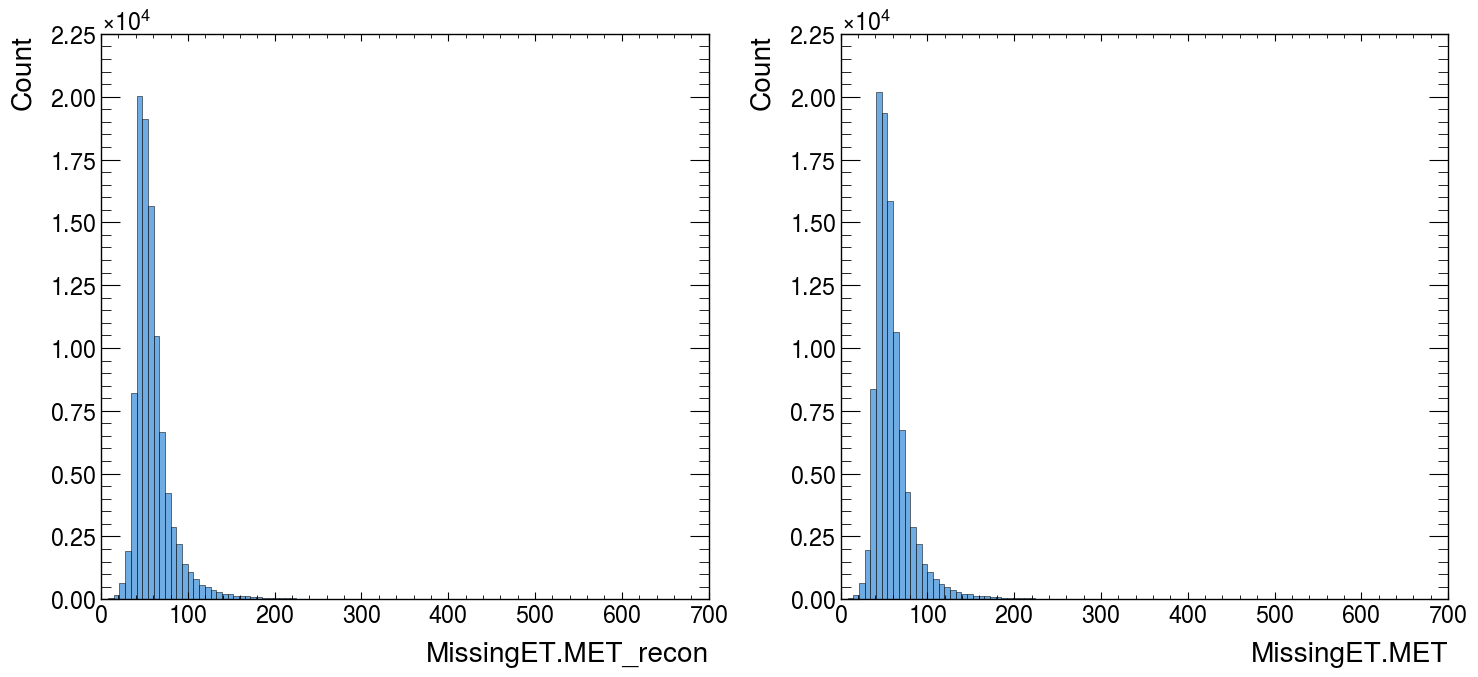

In [33]:
fig, axes=plt.subplots(1,2,figsize=[15,7])
sns.histplot(particle_level_df['MissingET.MET_recon'],bins=100,ax=axes[0])
sns.histplot(particle_level_df['MissingET.MET'],bins=100,ax=axes[1])
plt.tight_layout()
plt.show()

In [24]:
particle_level_df['MissingET.MET']

0        51.313629
1        59.927177
2        64.277809
3        61.958134
4        46.614388
           ...    
99995    42.635872
99996    30.184313
99997     53.24654
99998    37.049622
99999    71.950104
Name: MissingET.MET, Length: 100000, dtype: object

<Axes: xlabel='MissingET.MET', ylabel='Count'>

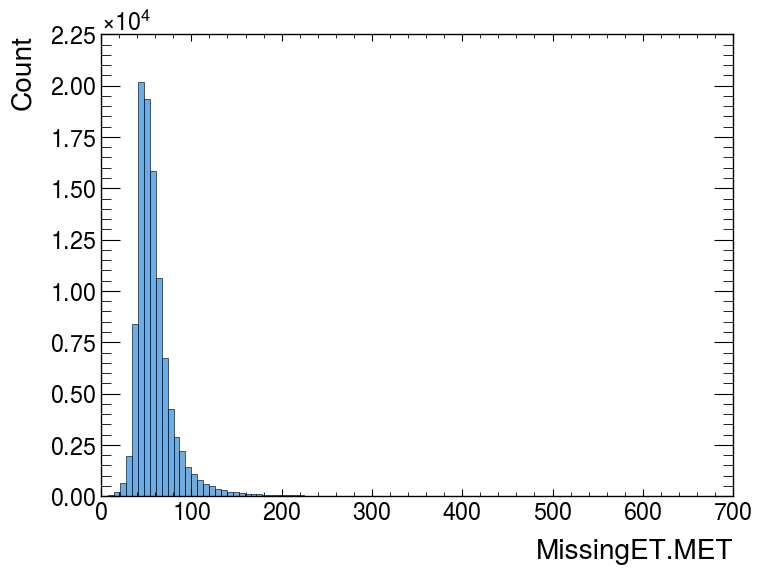

In [25]:
sns.histplot(particle_level_df['MissingET.MET'],bins=100)

In [35]:
CMS_cut_initial=particle_level_df.copy()
CMS_cut_initial=CMS_cut_initial.loc[ ((CMS_cut_initial['Photon_size']==1) & (CMS_cut_initial['MissingET_size']==1) & ((CMS_cut_initial['Muon_size']==1)) & ( CMS_cut_initial['Electron_size']==0 ) ) |
                           ((CMS_cut_initial['Photon_size']==1) & (CMS_cut_initial['MissingET_size']==1) & ((CMS_cut_initial['Electron_size']==1))   &( CMS_cut_initial['Muon_size']==0) )  ].copy()


In [82]:
CMS_cut_initial.head(10)

2

In [38]:
import awkward

In [39]:
def extract_single_element(x):
        if isinstance(x, list) or isinstance(x,np.ndarray) or isinstance(x,awkward.highlevel.Array):
            #print(x)
            if len(x) == 1:
                return x[0]
            elif len(x)==0:
                return np.nan
            elif len(x)>1:
                return np.array(x)
        elif isinstance(x, (np.float32, np.float64, float,int)): 
            return x
        else:
            return np.nan  # If
CMS_cut_initial = CMS_cut_initial.map(extract_single_element)

In [29]:
CMS_cut_initial.head(15)

,Muon.PT,Muon.Phi,Muon.Eta,Muon.Charge,Electron.PT,Electron.Phi,Electron.Eta,Electron.Charge,MissingET.MET_recon,MissingET.Phi_recon,...,Electron_size,MissingET_size,Photon.PT,Photon.Phi,Photon.Eta,Photon_size,Jet_size,Jet.PT,Jet.Eta,Jet.Phi
0,28.277042,0.345399,-0.552860,1.0,NaN,NaN,NaN,NaN,51.313629,-0.719651,...,0,1,66.902657,2.804712,-1.936580,1,NaN,"[67.138336, 31.22802]","[-1.9360662, -0.5551426]","[2.8059409, 0.37733823]"
1,23.673018,2.750550,1.636949,-1.0,NaN,NaN,NaN,NaN,59.927177,-0.447010,...,0,1,29.573936,-3.099234,2.292652,1,NaN,"[32.405365, 25.509573]","[2.3334208, 1.6550184]","[-3.1290507, 2.743121]"
2,NaN,NaN,NaN,NaN,42.136036,-0.901897,0.159411,1.0,64.388763,-2.159974,...,1,1,73.755959,1.687563,1.859125,1,NaN,"[74.59336, 45.077477]","[1.8608116, 0.16386949]","[1.6902964, -0.90538186]"
3,30.364132,0.481682,2.124929,1.0,NaN,NaN,NaN,NaN,61.958134,2.687866,...,0,1,57.194256,-1.133350,0.423571,1,NaN,"[64.95035, 38.224083, 27.351656]","[0.43744448, 2.1942072, -1.9596919]","[-1.12379, 0.46633983, 2.0206013]"
4,33.813263,-2.742675,-1.909654,-1.0,NaN,NaN,NaN,NaN,46.614388,-0.098160,...,0,1,45.265724,2.124459,0.115098,1,NaN,"[45.752544, 35.107075]","[0.10548884, -1.9068209]","[2.1232002, -2.7433436]"
5,273.477753,1.540903,-1.688000,-1.0,NaN,NaN,NaN,NaN,51.368141,1.191054,...,0,1,294.640686,-1.510407,-0.964824,1,NaN,"[296.49478, 276.0897, 79.31305, 24.463852]","[-0.967994, -1.6916267, 0.9405307, -2.8261626]","[-1.5105324, 1.5404868, -2.5290394, 0.21025585]"
6,41.417007,1.523452,-0.283276,-1.0,NaN,NaN,NaN,NaN,44.267738,-0.551042,...,0,1,39.847118,-2.769364,0.349910,1,NaN,"[42.777317, 41.218605]","[-0.27916026, 0.3486724]","[1.535423, -2.7646484]"
7,NaN,NaN,NaN,NaN,49.420326,1.587958,-0.698437,1.0,64.896988,-3.097778,...,1,1,58.986401,-0.662081,0.256667,1,NaN,"[64.04909, 51.608196, 26.855968]","[0.269366, -0.7141023, 2.6134036]","[-0.64976954, 1.6055652, 1.3122963]"
8,36.109951,-2.950005,-0.658811,1.0,NaN,NaN,NaN,NaN,42.097141,-2.747030,...,0,1,78.027679,0.450240,1.210558,1,NaN,"[80.7493, 36.868427]","[1.2132087, -0.65725535]","[0.4508069, -2.9519322]"
9,NaN,NaN,NaN,NaN,11.031571,0.338760,-1.773130,1.0,51.195686,-2.910819,...,1,1,40.935436,0.272660,1.570815,1,NaN,44.549252,1.609965,0.276952


In [40]:
CMS_cut=CMS_cut_func(CMS_cut_initial)

In [34]:
CMS_cut.head(15)

NameError: name 'CMS_cut' is not defined

In [93]:
CMS_cut['Photon.PT'][7]

58.98640060424805

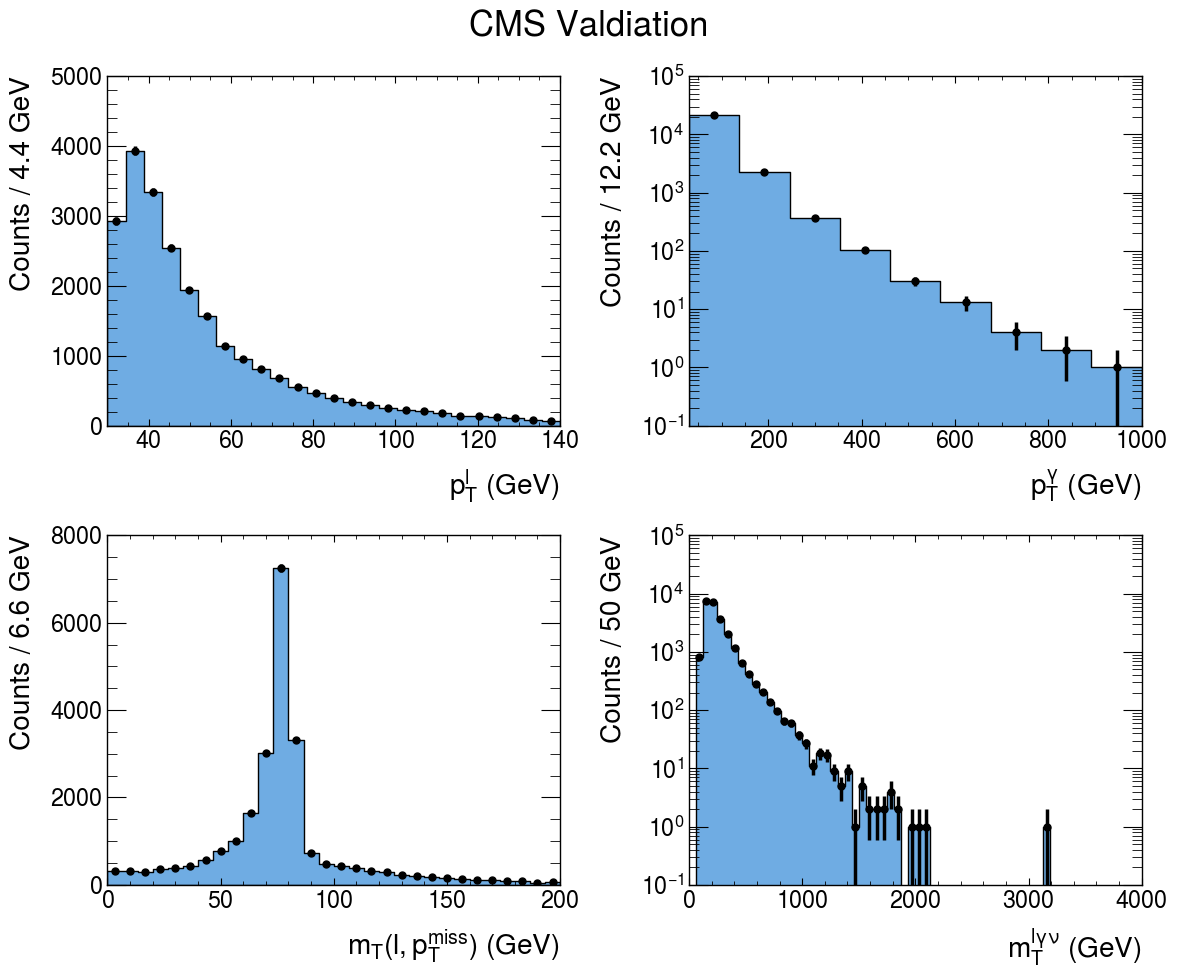

In [41]:
cross_section_inclusive=ufloat(0.9919,0.0016)
FILE_SIZE=len(events_df)

#138*995.7/np.sum(events_df_full['Event.Weight'])


e=len(CMS_cut)/FILE_SIZE
epsilon=ufloat(   e, np.sqrt( e*(1-e)/FILE_SIZE  )  )

cross_section_integrated=cross_section_inclusive*epsilon *1000


fig,axes=plt.subplots(2,2,figsize=(12,10))


Pt_lepton=pd.concat([CMS_cut['Muon.PT'],CMS_cut['Electron.PT']],axis=0,ignore_index=True)
var=Pt_lepton
#weight=pd.concat([CMS_cut['Event.Weight'],CMS_cut['Event.Weight']],axis=0,ignore_index=True)

counts, bins = np.histogram(var, 25,range=(30, 140))#,weights=weight)
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(x=var,bins=25,element='step',binrange=[30,140],edgecolor='black',ax=axes[0][0])#,weights=weight)
axes[0][0].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')

axes[0][0].set_xlim(30,140)
axes[0][0].set_ylabel('Counts / 4.4 GeV')
axes[0][0].set_xlabel(r'$\mathrm{p_{T}^{l}}$'+' (GeV)')




Pt_photon=CMS_cut['Photon.PT']
var=Pt_photon

counts, bins = np.histogram(var, 9,range=(30, 1000))#,weights=CMS_cut['Event.Weight'])
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(x=var,bins=9,element='step',edgecolor='black',binrange=[30,1000],ax=axes[0][1])#,weights=CMS_cut['Event.Weight'])
axes[0][1].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
axes[0][1].set_yscale('log')
axes[0][1].set_ylabel('Counts / 12.2 GeV')
axes[0][1].set_xlabel(r'$\mathrm{p_{T}^{\gamma}}$'+' (GeV)')
axes[0][1].set_xlim(30,1000)






var=CMS_cut['Mt_lv']

counts, bins = np.histogram(var, 30,range=(0, 200))#,weights=CMS_cut['Event.Weight'])
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(x=var,bins=30,element='step',edgecolor='black',binrange=[0,200],ax=axes[1][0])#,weights=CMS_cut['Event.Weight'])
axes[1][0].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
axes[1][0].set_ylabel('Counts / 6.6 GeV')
axes[1][0].set_xlabel(r'$\mathrm{m_{T}(l,p_{T}^{miss})}$'+' (GeV)')






var=CMS_cut['Mt_cluster']

counts, bins = np.histogram(var, 50)#,weights=CMS_cut['Event.Weight'])
bin_centres = (bins[:-1] + bins[1:])/2.
err = np.sqrt(counts)
sns.histplot(x=var,bins=50,element='step',edgecolor='black',ax=axes[1][1])#,weights=CMS_cut['Event.Weight'])
axes[1][1].errorbar(bin_centres,counts,yerr=err,fmt='o',color='black',markersize=5,elinewidth=2.5,label='Data')
axes[1][1].set_yscale('log')
axes[1][1].set_ylabel('Counts / 50 GeV')
axes[1][1].set_xlabel(r'$\mathrm{m_{T}^{l \gamma \nu}}$'+' (GeV)')

plt.suptitle('CMS Valdiation Particle level',size=25)


plt.tight_layout()
plt.show()



In [9]:
def extract_single_element(x):
        if isinstance(x, list) or isinstance(x,np.ndarray):
            if len(x) == 1:
                return x[0]
            elif len(x)==0:
                return np.nan
            elif len(x)>1:
                return np.array(x)
        elif isinstance(x, (np.float32, np.float64, float,int)): 
            return x
        else:
            return np.nan  # If
CMS_cut_initial = CMS_cut_initial.map(extract_single_element)

In [10]:
CMS_cut_initial=CMS_cut_initial.loc[ ((CMS_cut_initial['Photon_size']==1) & (CMS_cut_initial['MissingET_size']==1) & ((CMS_cut_initial['Muon_size']==1)) & ( CMS_cut_initial['Electron_size']==0 ) ) |
                           ((CMS_cut_initial['Photon_size']==1) & (CMS_cut_initial['MissingET_size']==1) & ((CMS_cut_initial['Electron_size']==1))   &( CMS_cut_initial['Muon_size']==0) )  ].copy()


CMS_cut=CMS_cut_initial.loc[(CMS_cut_initial['MissingET.MET']>40) &(CMS_cut_initial['Photon.PT']>30) & (np.abs(CMS_cut_initial['Photon.Eta'])<2.5)&
              
              ( (CMS_cut_initial['Electron.PT']>35) | (CMS_cut_initial['Muon.PT']>30) ) 
             &
               (  (    (np.abs(CMS_cut_initial['Electron.Eta'])<1.44) | (np.abs(CMS_cut_initial['Electron.Eta'])>1.57)      &  
                       (np.abs(CMS_cut_initial['Electron.Eta'])<2.5)    )          | (np.abs(CMS_cut_initial['Muon.Eta'])<2.4)  )  
               
                &(    (  np.sqrt((CMS_cut_initial['Electron.Eta'] - CMS_cut_initial['Photon.Eta'])**2 +(CMS_cut_initial['Electron.Phi'] -CMS_cut_initial['Photon.Phi'] )**2  )>0.7
                       )  |
                       ( np.sqrt((CMS_cut_initial['Muon.Eta'] - CMS_cut_initial['Photon.Eta'])**2 +(CMS_cut_initial['Muon.Phi'] -CMS_cut_initial['Photon.Phi'] )**2  )>0.7)       )
              ].copy()
CMS_cut['lepton_mass']=0.0
CMS_cut.loc[CMS_cut['Muon_size']==1,'lepton_mass']=particle.Particle.from_pdgid(13).mass/1000
CMS_cut.loc[CMS_cut['Electron_size']==1,'lepton_mass']=particle.Particle.from_pdgid(11).mass/1000

CMS_cut['M_ly']=0.0

CMS_cut.loc[CMS_cut['Muon_size']==1,'M_ly']=np.sqrt(       
    (CMS_cut['Photon.PT']*np.cosh(CMS_cut['Photon.Eta'])  + np.sqrt(   (CMS_cut['Muon.PT']*np.cosh(CMS_cut['Muon.Eta']))**2+CMS_cut['lepton_mass']**2    )  )**2  
        - (   CMS_cut['Muon.PT']*np.cos(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi'])  )**2
        - (   CMS_cut['Muon.PT']*np.sin(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi'])  )**2
        - (   CMS_cut['Muon.PT']*np.sinh(CMS_cut['Muon.Eta']) +CMS_cut['Photon.PT']*np.sinh(CMS_cut['Photon.Eta'])  )**2
            )
CMS_cut.loc[CMS_cut['Electron_size']==1,'M_ly']=np.sqrt(       
    (CMS_cut['Photon.PT']*np.cosh(CMS_cut['Photon.Eta'])  + np.sqrt(   (CMS_cut['Electron.PT']*np.cosh(CMS_cut['Electron.Eta']))**2+CMS_cut['lepton_mass']**2    )  )**2  
        - (   CMS_cut['Electron.PT']*np.cos(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi'])  )**2
        - (   CMS_cut['Electron.PT']*np.sin(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi'])  )**2
        - (   CMS_cut['Electron.PT']*np.sinh(CMS_cut['Electron.Eta']) +CMS_cut['Photon.PT']*np.sinh(CMS_cut['Photon.Eta'])  )**2
            )


CMS_cut=CMS_cut.loc[   (((CMS_cut['M_ly']<70)|(CMS_cut['M_ly']>110)  ) & (CMS_cut['Electron_size']==1)) |
                (((CMS_cut['M_ly']<70)|(CMS_cut['M_ly']>100)  ) & (CMS_cut['Muon_size']==1))
].copy()

CMS_cut['Mt_lv']=0.0


CMS_cut.loc[CMS_cut['Electron_size']==1,'Mt_lv']=np.sqrt(  
    ( CMS_cut['MissingET.MET']+ np.sqrt((CMS_cut['Electron.PT'])**2+CMS_cut['lepton_mass']**2))**2 
    - (   CMS_cut['Electron.PT']*np.cos(CMS_cut['Electron.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi'])  )**2
        - (   CMS_cut['Electron.PT']*np.sin(CMS_cut['Electron.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi'])  )**2   )

CMS_cut.loc[CMS_cut['Muon_size']==1,'Mt_lv']=np.sqrt(  
    ( CMS_cut['MissingET.MET']+ np.sqrt((CMS_cut['Muon.PT'])**2+CMS_cut['lepton_mass']**2))**2 
    - (   CMS_cut['Muon.PT']*np.cos(CMS_cut['Muon.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi'])  )**2
        - (   CMS_cut['Muon.PT']*np.sin(CMS_cut['Muon.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi'])  )**2   )

CMS_cut['Mt_cluster']=0.0

CMS_cut.loc[CMS_cut['Electron_size']==1,'Mt_cluster']=np.sqrt(  (np.sqrt( CMS_cut['M_ly']**2  +
                                                                        (CMS_cut['Electron.PT']*np.cos(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi'])  )**2 + 
                                                                        (CMS_cut['Electron.PT']*np.sin(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi'])  )**2    )+ 
                                                                        CMS_cut['MissingET.MET']  )**2  -  
                                                                        (CMS_cut['Electron.PT']*np.cos(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi']) )**2 - 
                                                                            (CMS_cut['Electron.PT']*np.sin(CMS_cut['Electron.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi']))**2  )




CMS_cut.loc[CMS_cut['Muon_size']==1,'Mt_cluster']=np.sqrt(  (np.sqrt( CMS_cut['M_ly']**2  +
                                                                        (CMS_cut['Muon.PT']*np.cos(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi'])  )**2 + 
                                                                        (CMS_cut['Muon.PT']*np.sin(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi'])  )**2    )+ 
                                                                        CMS_cut['MissingET.MET']  )**2  -  
                                                                        (CMS_cut['Muon.PT']*np.cos(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.cos(CMS_cut['Photon.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi']) )**2 - 
                                                                            (CMS_cut['Muon.PT']*np.sin(CMS_cut['Muon.Phi']) +CMS_cut['Photon.PT']*np.sin(CMS_cut['Photon.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi']))**2  )




In [170]:

W_boson=particle.Particle.from_pdgid(24)
M_w=W_boson.mass/1000

CMS_cut['large_boost']=0.0
CMS_cut.loc[CMS_cut['Electron_size']==1,'large_boost']=M_w**2/(CMS_cut['Electron.PT']*CMS_cut['MissingET.MET'])
CMS_cut.loc[CMS_cut['Muon_size']==1,'large_boost']=M_w**2/(CMS_cut['Muon.PT']*CMS_cut['MissingET.MET'])

CMS_cut['delta']=0.0
CMS_cut.loc[CMS_cut['Electron_size']==1,'delta']=(M_w**2-CMS_cut['Mt_lv']**2)/(2*CMS_cut['Electron.PT']*CMS_cut['MissingET.MET'])
CMS_cut.loc[CMS_cut['Muon_size']==1,'delta']=(M_w**2-CMS_cut['Mt_lv']**2)/(2*CMS_cut['Muon.PT']*CMS_cut['MissingET.MET'])

In [171]:
np.random.seed(42)
CMS_cut['lepton_mass']=0.0
CMS_cut.loc[CMS_cut['Muon_size']==1,'lepton_mass']=particle.Particle.from_pdgid(13).mass/1000
CMS_cut.loc[CMS_cut['Electron_size']==1,'lepton_mass']=particle.Particle.from_pdgid(11).mass/1000
CMS_cut['Mt_lv']=0.0


CMS_cut.loc[CMS_cut['Electron_size']==1,'Mt_lv']=np.sqrt(  
    ( CMS_cut['MissingET.MET']+ np.sqrt((CMS_cut['Electron.PT'])**2+CMS_cut['lepton_mass']**2))**2 
    - (   CMS_cut['Electron.PT']*np.cos(CMS_cut['Electron.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi'])  )**2
        - (   CMS_cut['Electron.PT']*np.sin(CMS_cut['Electron.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi'])  )**2   )

CMS_cut.loc[CMS_cut['Muon_size']==1,'Mt_lv']=np.sqrt(  
    ( CMS_cut['MissingET.MET']+ np.sqrt((CMS_cut['Muon.PT'])**2+CMS_cut['lepton_mass']**2))**2 
    - (   CMS_cut['Muon.PT']*np.cos(CMS_cut['Muon.Phi']) +CMS_cut['MissingET.MET']*np.cos(CMS_cut['MissingET.Phi'])  )**2
        - (   CMS_cut['Muon.PT']*np.sin(CMS_cut['Muon.Phi']) +CMS_cut['MissingET.MET']*np.sin(CMS_cut['MissingET.Phi'])  )**2   )


CMS_cut['large_boost']=0.0
CMS_cut.loc[CMS_cut['Electron_size']==1,'large_boost']=M_w**2/(CMS_cut['Electron.PT']*CMS_cut['MissingET.MET'])
CMS_cut.loc[CMS_cut['Muon_size']==1,'large_boost']=M_w**2/(CMS_cut['Muon.PT']*CMS_cut['MissingET.MET'])

CMS_cut['delta']=0.0
CMS_cut.loc[CMS_cut['Electron_size']==1,'delta']=(M_w**2-CMS_cut['Mt_lv']**2)/(2*CMS_cut['Electron.PT']*CMS_cut['MissingET.MET'])
CMS_cut.loc[CMS_cut['Muon_size']==1,'delta']=(M_w**2-CMS_cut['Mt_lv']**2)/(2*CMS_cut['Muon.PT']*CMS_cut['MissingET.MET'])


CMS_cut['sign']=np.sign(CMS_cut['delta'])
CMS_cut.loc[(CMS_cut['sign']==-1.0) & (CMS_cut['Electron_size']==1),'Eta_v']=CMS_cut['Electron.Eta']
CMS_cut.loc[(CMS_cut['sign']==-1.0) & (CMS_cut['Muon_size']==1),'Eta_v']=CMS_cut['Muon.Eta']


def random_eta(row):
    eta_plus = row['Electron.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    eta_minus = row['Electron.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    return np.random.choice([eta_plus, eta_minus])
CMS_cut.loc[(CMS_cut['Electron_size'] == 1) & (CMS_cut['delta'] >= 0), 'Eta_v'] = CMS_cut[(CMS_cut['Electron_size'] == 1) & (CMS_cut['delta'] >= 0)].apply(random_eta, axis=1)


def random_eta(row):
    eta_plus = row['Muon.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    eta_minus = row['Muon.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
    return np.random.choice([eta_plus, eta_minus])
CMS_cut.loc[(CMS_cut['Muon_size'] == 1) & (CMS_cut['delta'] >= 0), 'Eta_v'] = CMS_cut[(CMS_cut['Muon_size'] == 1) & (CMS_cut['delta'] >= 0)].apply(random_eta, axis=1)


In [11]:
def phi_transf(phi):
    return np.piecewise(
    phi,
    [
        phi < -np.pi / 2,  
        np.abs(phi) < np.pi / 2,  
        phi > np.pi / 2  
    ],
    [
        lambda phi: -(np.pi + phi),  
        lambda phi: phi,  
        lambda phi: np.pi - phi  
    ]
)

def phi_recon(charge,particle):

    p_l=vector.zip({'pt':CMS_cut[particle+'.PT'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)] ,'eta':CMS_cut[particle+'.Eta'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],
                    'phi':CMS_cut[particle+'.Phi'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],'mass':CMS_cut['lepton_mass'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)]  })
    p_y=vector.zip({'pt':CMS_cut['Photon.PT'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)] ,'eta':CMS_cut['Photon.Eta'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],
                    'phi':CMS_cut['Photon.Phi'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],'mass':0 })

    p_vl=vector.zip({'pt':CMS_cut['MissingET.MET'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)] ,'eta':CMS_cut['MissingET.Eta'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],
                'phi':CMS_cut['MissingET.Phi'].loc[(CMS_cut[particle+'_size']==1) & (CMS_cut[particle+'.Charge']==charge)],'mass':0 })


    p_w=p_l+p_vl
    p_com=p_w+p_y
    p_w_boosted=p_w.boost(-p_com.to_beta3())
    p_l_boosted=p_l.boost(-p_com.to_beta3())
    p_vl_boosted=p_vl.boost(-p_com.to_beta3())

    n1=p_w_boosted.to_Vector3D().cross(-p_com.to_Vector3D())    
    n1=n1/n1.mag

    n_ref=n1.cross(p_w_boosted.to_Vector3D())
    n_ref=n_ref/n_ref.mag
    if charge==1.0:
        n2=-p_l_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
    elif charge==-1.0:
        n2=-p_vl_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
    else: return 'error'

    n2=n2/n2.mag   

    x=n2.dot(n1)
    y=n2.dot(n_ref)

    phi=-np.arctan2(y,x)
    phi=np.array(phi)

    return phi_transf(phi)



CMS_cut['Phi']=0.0

CMS_cut.loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0),'phi']=phi_recon(1.0,'Electron')
CMS_cut.loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==-1.0),'phi']=phi_recon(-1.0,'Electron')

CMS_cut.loc[(CMS_cut['Muon_size']==1) & (CMS_cut['Muon.Charge']==1.0),'phi']=phi_recon(1.0,'Muon')
CMS_cut.loc[(CMS_cut['Muon_size']==1) & (CMS_cut['Muon.Charge']==-1.0),'phi']=phi_recon(-1.0,'Muon')

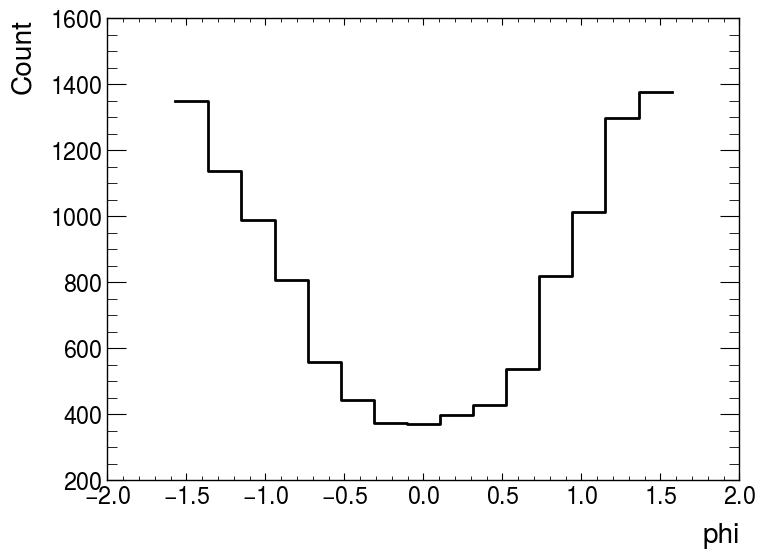

In [191]:
sns.histplot(CMS_cut['phi'],bins=15,element='step',fill=None,color='Black')
plt.show()

In [12]:
len(CMS_cut)

23901

In [ ]:
len

In [193]:

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.offline as pyo

P_l=vector.zip({'pt':CMS_cut['Electron.PT'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)] ,'eta':CMS_cut['Electron.Eta'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],
                'phi':CMS_cut['Electron.Phi'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],'mass':CMS_cut['lepton_mass'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)]  })
P_y=vector.zip({'pt':CMS_cut['Photon.PT'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)] ,'eta':CMS_cut['Photon.Eta'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],
                'phi':CMS_cut['Photon.Phi'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],'mass':0 })

P_vl=vector.zip({'pt':CMS_cut['MissingET.MET'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)] ,'eta':CMS_cut['MissingET.Eta'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],
                'phi':CMS_cut['MissingET.Phi'].loc[(CMS_cut['Electron_size']==1) & (CMS_cut['Electron.Charge']==1.0)],'mass':0 })


P_w=P_l+P_vl
P_com=P_w+P_y

P_w_boosted=P_w.boost(-P_com.to_beta3())
P_y_boosted=P_y.boost(-P_com.to_beta3())
P_l_boosted=P_l.boost(-P_com.to_beta3())
P_vl_boosted=P_vl.boost(-P_com.to_beta3())

n1=P_w_boosted.to_Vector3D().cross(-P_com.to_Vector3D())    
n1=n1/n1.mag

n_ref=n1.cross(P_w_boosted.to_Vector3D())
n_ref=n_ref/n_ref.mag

n2=-P_l_boosted.to_Vector3D().cross(P_w_boosted.to_Vector3D())
n2=n2/n2.mag


v = P_w_boosted.to_Vector3D()
v=v/v.mag
v=v[0]
v2=P_y_boosted.to_Vector3D()
v2=v2[0]
v2=v2/v2.mag


l=P_l_boosted.to_Vector3D()
l=l[0]
l=l/l.mag

vl=P_vl_boosted.to_Vector3D()
vl=vl[0]
vl=vl/vl.mag

r=P_com.to_Vector3D()

r=r[0]
r=r/r.mag

fig = go.Figure()

fig.add_trace(go.Scatter3d(x=[0, v.x], y=[0, v.y], z=[0, v.z],
                           mode='lines',
                           #marker=dict(size=5, color='green'),
                           line=dict(width=5, color='green'),name='w'))
fig.add_trace(go.Scatter3d(x=[0, v2.x], y=[0, v2.y], z=[0, v2.z],
                           mode='lines',
                           #marker=dict(size=5, color='yellow'),
                           line=dict(width=5, color='yellow'),name='y'))


fig.add_trace(go.Scatter3d(x=[0, n1[0].x], y=[0, n1[0].y], z=[0, n1[0].z],
                           mode='lines',
                           marker=dict(size=5, color='blue'),
                           line=dict(width=5, color='black'),name='n1'))



fig.add_trace(go.Scatter3d(x=[0, n_ref[0].x], y=[0, n_ref[0].y], z=[0, n_ref[0].z],
                           mode='lines',
                           #marker=dict(size=5, color='blue'),
                           line=dict(width=5, color='black'),name='n_ref'))

fig.add_trace(go.Scatter3d(x=[v.x,v.x+ l.x], y=[v.y, v.y+l.y], z=[v.z, v.z+l.z],
                           mode='lines',
                           
                           line=dict(width=5, color='blue'),name='electron'))

fig.add_trace(go.Scatter3d(x=[v.x, v.x+vl.x], y=[v.y, v.y+vl.y], z=[v.z,v.z+ vl.z],
                           mode='lines',
                          
                           line=dict(width=5, color='cyan'),name='muon'))

fig.add_trace(go.Scatter3d(x=[v.x,v.x+ n2[0].x], y=[v.y, v.y+n2[0].y], z=[v.z, v.z+n2[0].z],
                           mode='lines',
                           
                           line=dict(width=5, color='purple'),name='n2'))

#fig.add_trace(go.Scatter3d(x=[0, n2[0].x], y=[0, n2[0].y], z=[0, n2[0].z],
#                           mode='lines+markers',
#                           marker=dict(size=5, color='blue'),
#                           line=dict(width=5, color='purple'),name='n2'))

fig.add_trace(go.Scatter3d(x=[-r.x, r.x], y=[-r.y,r.y], z=[-r.z,r.z],
                           mode='lines',
                           
                           line=dict(width=6, color='red',dash='dot'),name='boost dir'))

u1 = np.linspace(-1, 1, 20)
v1 = np.linspace(-1, 1, 20)
U, V = np.meshgrid(u1, v1)

plane_x = U * v.x + V * r.x
plane_y = U * v.y + V * r.y
plane_z = U * v.z + V * r.z

plane_x_1 = v.x + U * l.x + V * vl.x
plane_y_1 = v.y + U * l.y + V * vl.y
plane_z_1 = v.z + U * l.z + V * vl.z



fig.add_trace(go.Surface(x=plane_x, y=plane_y, z=plane_z, opacity=0.4, colorscale=[[0, 'gray'], [1, 'gray']],showscale=False, name='plane1'))

fig.add_trace(go.Surface(x=plane_x_1, y=plane_y_1, z=plane_z_1, opacity=0.3, colorscale=[[0, 'blue'], [1, 'blue']],showscale=False, name='plane2'))




fig.add_trace(go.Cone(
    x=[v.x], y=[v.y], z=[v.z], 
    u=[v.x], v=[v.y], w=[v.z], 
    sizemode="absolute", sizeref=0.2, anchor="tip", colorscale=[[0, 'green'], [1, 'green']],
    showscale=False, name='w arrow'))

fig.add_trace(go.Cone(
    x=[v2.x], y=[v2.y], z=[v2.z], 
    u=[v2.x], v=[v2.y], w=[v2.z], 
    sizemode="absolute", sizeref=0.2, anchor="tip", colorscale=[[0, 'yellow'], [1, 'yellow']],
    showscale=False, name='y arrow'))

fig.add_trace(go.Cone(
    x=[v.x + l.x], y=[v.y + l.y], z=[v.z + l.z], 
    u=[l.x], v=[l.y], w=[l.z], 
    sizemode="absolute", sizeref=0.2, anchor="tip", colorscale=[[0, 'blue'], [1, 'blue']],
    showscale=False, name='electron arrow'))

fig.add_trace(go.Cone(
    x=[v.x + vl.x], y=[v.y + vl.y], z=[v.z + vl.z], 
    u=[vl.x], v=[vl.y], w=[vl.z], 
    sizemode="absolute", sizeref=0.2, anchor="tip", colorscale=[[0, 'cyan'], [1, 'cyan']],
    showscale=False, name='muon arrow'))


fig.update_layout(scene=dict(
    xaxis=dict(showbackground=False),  
    yaxis=dict(showbackground=False),  
    zaxis=dict(showbackground=False),  
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))

pyo.plot(fig, filename='3d_vector_plot.html')

'3d_vector_plot.html'